# Cal-CRAI Index Calculation Testing

Note: Functions and figures within this notebook are in development

In [64]:
import pandas as pd
import os
import sys
import numpy as np
import shutil
import glob
import geopandas as gpd
import matplotlib.pyplot as plt

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.write_metadata import append_metadata
from scripts.utils.index_plot import index_plot
from scripts.utils.calculate_index import handle_outliers, min_max_standardize

## Pulling all calculated metric files

In [65]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/'

pull_csv_from_directory(bucket_name, aws_dir, search_zipped=False)

Saved DataFrame as 'built_energy_transmission_lines_metric.csv'
Saved DataFrame as 'built_housing_median_age_metric.csv'
Saved DataFrame as 'built_housing_mobile_homes_metric.csv'
Saved DataFrame as 'built_housing_quality_metric.csv'
Saved DataFrame as 'built_metric_housing_vacancy_metric.csv'
Saved DataFrame as 'built_power_plant_metric.csv'
Saved DataFrame as 'built_power_shutoffs_metric.csv'
Saved DataFrame as 'built_wastewater_treatment_facilities_metric.csv'
Saved DataFrame as 'climate_drought_coverage_metric.csv'
Saved DataFrame as 'climate_drought_crop_loss_acres_metric.csv'
Saved DataFrame as 'climate_drought_crop_loss_cost_metric.csv'
Saved DataFrame as 'climate_drought_total_weeks.csv'
Saved DataFrame as 'climate_extreme_heat_hot_day_metric.csv'
Saved DataFrame as 'climate_extreme_heat_warm_night_metric.csv'
Saved DataFrame as 'climate_flood_claims_metric.csv'
Saved DataFrame as 'climate_flood_cost_metric.csv'
Saved DataFrame as 'climate_flood_crop_loss_metric.csv'
Saved Data

## Selecting files specifically for society domain

In [66]:
# Define the output folder path
output_folder = 'output_folder'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Find all CSV files starting with 'society_'
source_files = [file for file in glob.glob('society_*.csv') if 'social' not in file]

# Iterate through the source files and copy only CSV files to the output folder
for file in source_files:
    # Construct the destination file path
    destination_path = os.path.join(output_folder, os.path.basename(file))
    
    # Copy the file to the output folder
    shutil.copyfile(file, destination_path)
    
    # Remove the original file
    os.remove(file)

print(f"Copied and removed {len(source_files)} CSV files.")

# Delete all CSV files in the current directory that are not in the output folder
current_files = glob.glob('*.csv')
for file in current_files:
    if file not in [os.path.basename(f) for f in source_files]:
        os.remove(file)

print(f"Deleted {len(current_files) - len(source_files)} local CSV files.")


Copied and removed 33 CSV files.
Deleted 46 local CSV files.


## Placing relevant files in a folder and removing others

In [67]:
# Define the output folder path
output_folder = 'output_folder'

# Get a list of all CSV files in the output folder
csv_files = glob.glob(os.path.join(output_folder, '*.csv'))

# Initialize an empty DataFrame for merging
merged_df = pd.DataFrame()
# Iterate through each CSV file and merge them on the 'census_tract' column
for file in csv_files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    
    # Rename 'GEO_ID' or 'tract' to 'census_tract' if they exist
    if 'GEO_ID' in df.columns:
        df.rename(columns={'GEO_ID': 'census_tract'}, inplace=True)
    elif 'tract' in df.columns:
        df.rename(columns={'tract': 'census_tract'}, inplace=True)
    elif 'TRACT' in df.columns:
        df.rename(columns={'TRACT': 'census_tract'}, inplace=True)
        
    # Keep only the 'census_tract' and the last column from each file
    last_column = df.columns[-1]
    df = df[['census_tract', last_column]]
    
    # Merge the DataFrame with the existing merged DataFrame
    if merged_df.empty:
        merged_df = df
    else:
        merged_df = pd.merge(merged_df, df, on='census_tract', how='outer')

# Save the merged DataFrame to a CSV file
merged_df.to_csv('concatenate_society_economy_metrics.csv', index=False)

print(f"Merged CSV saved as concatenate_society_economy_metrics.csv")

Merged CSV saved as concatenate_society_economy_metrics.csv


In [68]:
society_economy_metrics = pd.read_csv('concatenate_society_economy_metrics.csv')

# Drop rows where 'census_tract' is NaN
society_economy_metrics = society_economy_metrics.dropna(subset=['census_tract'])

# Convert census tract to string and eliminate scientific notation default
society_economy_metrics['census_tract'] = society_economy_metrics['census_tract'].dropna().apply(lambda x: '{:.0f}'.format(x))

# Convert all values within the island tract (near San Francisco) to nan, as it is uninhabited 
island_tract = '6075980401'
society_economy_metrics.loc[society_economy_metrics['census_tract'] == island_tract, 
                            society_economy_metrics.columns != 'census_tract'] = np.nan

society_economy_metrics

,census_tract,percent_population_ambulatory_disabilities,percent_total_pop_american_indian_alaska_native,blood and organ banks per 10000 people,percent_population_cognitive_disabilities,est_gini_index,hachman_index,est_median_income_dollars,percent_children_household_financial_assistance,percent_1miurban_10mirural,health and personal care stores per 10000 people,heavy and civil engineering construction per 10000 people,hospitals per 10000 people,avg_hpsscore_mental_shortage_metric,narcotic_support_per_10000,real_percent_total_pop_over_65,personal and household goods repair and maintenance per 10000 people,avg_hpsscore_primary_care_metric,specialty trade contractors per 10000 people,percent_total_pop_under_5,asthma_related_ed_visits_per_10000_people_2019,cardiovascular_disease_related_ed_visits_per_10000_people_2019,education_percent_2019,avg_percent_population_homeless,housing_burden_percent_2019,sum_imp_water_bodies,linguistic_isolation_percent_2019,low_birth_weight_percent_2019,Percent of households without air conditioning,Percent of population employed and aged > 16 working outdoors,poverty_percent_2019,unemployment_percent_2019,"Number of Violent Crimes per 10,000 Population",percent_population_without_health_insurance
0,6001400100,4.680330,0.0,0.042072,5.170005,0.4228,0.926769,234236,15.885023,58.256725,2.223794,0.679159,0.252431,NaN,0.048082,27.041909,0.504861,NaN,10.776387,4.1,50.160256,16.794872,3.300000,0.528619,11.200000,2.0,1.200000,3.850000,64.306645,0.919842,10.400000,4.823653,72.674237,0.275314
1,6001400200,4.005589,0.4,0.042072,1.904253,0.4084,0.926769,225500,0.000000,30.832177,2.223794,0.679159,0.252431,NaN,0.048082,25.756870,0.504861,NaN,10.776387,7.9,101.993024,40.558047,0.400000,0.528619,4.000000,0.0,0.000000,4.050000,64.306645,1.595745,10.600000,3.000000,72.674237,0.838379
2,6001400300,2.295782,0.5,0.042072,3.529687,0.4615,0.926769,164000,3.184713,30.832177,2.223794,0.679159,0.252431,NaN,0.048082,16.301833,0.504861,NaN,10.776387,2.3,61.136409,17.580677,5.600000,0.528619,8.900000,0.0,8.000000,3.780000,64.306645,1.152702,10.300000,3.900000,72.674237,1.655099
3,6001400400,3.646564,0.5,0.042072,3.165358,0.5063,0.926769,158836,14.240170,30.832177,2.223794,0.679159,0.252431,NaN,0.048082,12.856475,0.504861,NaN,10.776387,7.5,123.808335,20.164712,4.800000,0.528619,14.800000,0.0,0.900000,4.440000,64.306645,2.146272,21.100000,2.500000,72.674237,2.244039
4,6001400500,3.367941,0.1,0.042072,6.219631,0.4571,0.926769,95078,4.435484,30.832177,2.223794,0.679159,0.252431,NaN,0.048082,16.434540,0.504861,NaN,10.776387,4.0,209.917556,26.988361,2.300000,0.528619,14.800000,0.0,1.700000,3.640000,64.306645,3.771252,21.900000,3.800000,72.674237,4.482147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,0.535332,0.2,NaN,0.544662,0.4252,0.784133,54265,13.194444,0.000000,0.979132,1.223915,NaN,NaN,0.244783,0.000000,NaN,NaN,8.322624,12.3,226.557774,89.473684,2.100000,0.947555,35.200000,0.0,5.916667,4.330000,1.725293,6.049022,28.300000,3.400000,49.063183,1.445396
9125,6115041001,8.387800,0.3,NaN,3.745976,0.5024,0.784133,67321,0.000000,37.636696,0.979132,1.223915,NaN,NaN,0.244783,33.605664,NaN,NaN,8.322624,6.9,NaN,NaN,22.988889,0.947555,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,49.063183,2.777778
9126,6115041002,9.160082,2.6,NaN,9.702797,0.4875,0.784133,102534,0.000000,37.636696,0.979132,1.223915,NaN,NaN,0.244783,29.997073,NaN,NaN,8.322624,2.6,NaN,NaN,22.988889,0.947555,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,49.063183,15.510682
9127,6115041101,16.826923,1.1,NaN,9.405941,0.4072,0.784133,37018,44.331984,37.636696,0.979132,1.223915,NaN,NaN,0.244783,20.891608,NaN,NaN,8.322624,2.7,NaN,NaN,22.988889,0.947555,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,49.063183,7.430070


In [69]:
# Make sure all columns within the island tract are NaN
checking_island_tract = society_economy_metrics[society_economy_metrics['census_tract']=='6075980401']
checking_island_tract

,census_tract,percent_population_ambulatory_disabilities,percent_total_pop_american_indian_alaska_native,blood and organ banks per 10000 people,percent_population_cognitive_disabilities,est_gini_index,hachman_index,est_median_income_dollars,percent_children_household_financial_assistance,percent_1miurban_10mirural,health and personal care stores per 10000 people,heavy and civil engineering construction per 10000 people,hospitals per 10000 people,avg_hpsscore_mental_shortage_metric,narcotic_support_per_10000,real_percent_total_pop_over_65,personal and household goods repair and maintenance per 10000 people,avg_hpsscore_primary_care_metric,specialty trade contractors per 10000 people,percent_total_pop_under_5,asthma_related_ed_visits_per_10000_people_2019,cardiovascular_disease_related_ed_visits_per_10000_people_2019,education_percent_2019,avg_percent_population_homeless,housing_burden_percent_2019,sum_imp_water_bodies,linguistic_isolation_percent_2019,low_birth_weight_percent_2019,Percent of households without air conditioning,Percent of population employed and aged > 16 working outdoors,poverty_percent_2019,unemployment_percent_2019,"Number of Violent Crimes per 10,000 Population",percent_population_without_health_insurance
7295,6075980401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Checking to see if there are infinite values within our columns
* if so, replacing infinite values with NaN

In [70]:
# Selecting only numeric columns
numeric_df = society_economy_metrics.select_dtypes(include=[np.number])

# Counting infinite values
num_infinite = np.isinf(numeric_df).sum().sum()

print(f"\nNumber of infinite entries in the DataFrame: {num_infinite}")


Number of infinite entries in the DataFrame: 67


In [71]:
# Replace infinite values with NaN
society_economy_metrics.replace([np.inf, -np.inf], np.nan, inplace=True)

# Selecting only numeric columns
numeric_df = society_economy_metrics.select_dtypes(include=[np.number])

# Counting infinite values
num_infinite = np.isinf(numeric_df).sum().sum()

print(f"\nNumber of infinite entries in the DataFrame: {num_infinite}")


Number of infinite entries in the DataFrame: 0


## Call outlier function to handle outliers:
Max = 3 x 75th percentile
Min = -3 x 25th percentile

Outliers beyond these values are set to metric value closest to the fence
Baum et al. 1970

In [72]:
# Handle outliers
handle_outlier_csv = 'no_outlier_society_economy_metrics.csv'
output = handle_outliers(society_economy_metrics, handle_outlier_csv)
print(f"Processed and saved {handle_outlier_csv} with outlier handling.")

For column percent_population_ambulatory_disabilities:
  Q1 (25th percentile): 3.4249678882757117
  Q3 (75th percentile): 7.035102433873741
  IQR: 3.610134545598029
  Max fence: 21.105307301621224
  Min fence: -10.274903664827136
Outliers detected in column 'percent_population_ambulatory_disabilities':
census_tract: 6013351105, value: 21.223814773980155
census_tract: 6025012400, value: 21.39219015280136
census_tract: 6033000601, value: 22.210690192008304
census_tract: 6037125322, value: 21.15093387178193
census_tract: 6037206301, value: 31.129864041256443
census_tract: 6037206302, value: 25.71554381329811
census_tract: 6037206303, value: 28.146536089952846
census_tract: 6037302201, value: 22.377807133421403
census_tract: 6037310701, value: 22.231614539306847
census_tract: 6037980014, value: 48.888888888888886
census_tract: 6037980021, value: 23.52941176470588
census_tract: 6039000111, value: 21.643109540636043
census_tract: 6059021813, value: 84.61538461538461
census_tract: 6059099510,

In [73]:
# viewing new 'fenced' outliers
no_outlier_society_economy_metrics = pd.read_csv('no_outlier_society_economy_metrics.csv')
no_outlier_society_economy_metrics

,census_tract,percent_population_ambulatory_disabilities,percent_total_pop_american_indian_alaska_native,blood and organ banks per 10000 people,percent_population_cognitive_disabilities,est_gini_index,hachman_index,est_median_income_dollars,percent_children_household_financial_assistance,percent_1miurban_10mirural,health and personal care stores per 10000 people,heavy and civil engineering construction per 10000 people,hospitals per 10000 people,avg_hpsscore_mental_shortage_metric,narcotic_support_per_10000,real_percent_total_pop_over_65,personal and household goods repair and maintenance per 10000 people,avg_hpsscore_primary_care_metric,specialty trade contractors per 10000 people,percent_total_pop_under_5,asthma_related_ed_visits_per_10000_people_2019,cardiovascular_disease_related_ed_visits_per_10000_people_2019,education_percent_2019,avg_percent_population_homeless,housing_burden_percent_2019,sum_imp_water_bodies,linguistic_isolation_percent_2019,low_birth_weight_percent_2019,Percent of households without air conditioning,Percent of population employed and aged > 16 working outdoors,poverty_percent_2019,unemployment_percent_2019,"Number of Violent Crimes per 10,000 Population",percent_population_without_health_insurance
0,6001400100,4.680330,0.0,0.042072,5.170005,0.4228,0.926769,234236.0,15.885023,58.256725,2.223794,0.679159,0.252431,NaN,0.048082,27.041909,0.504861,NaN,10.776387,4.1,50.160256,16.794872,3.300000,0.528619,11.200000,2.0,1.200000,3.850000,64.306645,0.919842,10.400000,4.823653,72.674237,0.275314
1,6001400200,4.005589,0.4,0.042072,1.904253,0.4084,0.926769,225500.0,0.000000,30.832177,2.223794,0.679159,0.252431,NaN,0.048082,25.756870,0.504861,NaN,10.776387,7.9,101.993024,40.558047,0.400000,0.528619,4.000000,0.0,0.000000,4.050000,64.306645,1.595745,10.600000,3.000000,72.674237,0.838379
2,6001400300,2.295782,0.5,0.042072,3.529687,0.4615,0.926769,164000.0,3.184713,30.832177,2.223794,0.679159,0.252431,NaN,0.048082,16.301833,0.504861,NaN,10.776387,2.3,61.136409,17.580677,5.600000,0.528619,8.900000,0.0,8.000000,3.780000,64.306645,1.152702,10.300000,3.900000,72.674237,1.655099
3,6001400400,3.646564,0.5,0.042072,3.165358,0.5063,0.926769,158836.0,14.240170,30.832177,2.223794,0.679159,0.252431,NaN,0.048082,12.856475,0.504861,NaN,10.776387,7.5,123.808335,20.164712,4.800000,0.528619,14.800000,0.0,0.900000,4.440000,64.306645,2.146272,21.100000,2.500000,72.674237,2.244039
4,6001400500,3.367941,0.1,0.042072,6.219631,0.4571,0.926769,95078.0,4.435484,30.832177,2.223794,0.679159,0.252431,NaN,0.048082,16.434540,0.504861,NaN,10.776387,4.0,209.917556,26.988361,2.300000,0.528619,14.800000,0.0,1.700000,3.640000,64.306645,3.771252,21.900000,3.800000,72.674237,4.482147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,0.535332,0.2,NaN,0.544662,0.4252,0.784133,54265.0,13.194444,0.000000,0.979132,1.223915,NaN,NaN,0.144917,0.000000,NaN,NaN,8.322624,12.3,226.557774,89.473684,2.100000,0.947555,35.200000,0.0,5.916667,4.330000,1.725293,6.049022,28.300000,3.400000,49.063183,1.445396
9125,6115041001,8.387800,0.3,NaN,3.745976,0.5024,0.784133,67321.0,0.000000,37.636696,0.979132,1.223915,NaN,NaN,0.144917,33.605664,NaN,NaN,8.322624,6.9,NaN,NaN,22.988889,0.947555,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,49.063183,2.777778
9126,6115041002,9.160082,2.6,NaN,9.702797,0.4875,0.784133,102534.0,0.000000,37.636696,0.979132,1.223915,NaN,NaN,0.144917,29.997073,NaN,NaN,8.322624,2.6,NaN,NaN,22.988889,0.947555,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,49.063183,15.510682
9127,6115041101,16.826923,1.1,NaN,9.405941,0.4072,0.784133,37018.0,44.331984,37.636696,0.979132,1.223915,NaN,NaN,0.144917,20.891608,NaN,NaN,8.322624,2.7,NaN,NaN,22.988889,0.947555,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,49.063183,7.430070


## Metrics are now min-max standardized on 0.01 to 0.99 scale

In [74]:
# standardizing our df
min_max_metrics = no_outlier_society_economy_metrics.copy()
columns_to_process = [col for col in min_max_metrics.columns if col != 'census_tract']
min_max_metrics = min_max_standardize(min_max_metrics, columns_to_process)

min_max_metrics.head()

,census_tract,percent_population_ambulatory_disabilities_min,percent_population_ambulatory_disabilities_max,percent_population_ambulatory_disabilities_min_max_standardized,percent_total_pop_american_indian_alaska_native_min,percent_total_pop_american_indian_alaska_native_max,percent_total_pop_american_indian_alaska_native_min_max_standardized,blood and organ banks per 10000 people_min,blood and organ banks per 10000 people_max,blood and organ banks per 10000 people_min_max_standardized,percent_population_cognitive_disabilities_min,percent_population_cognitive_disabilities_max,percent_population_cognitive_disabilities_min_max_standardized,est_gini_index_min,est_gini_index_max,est_gini_index_min_max_standardized,hachman_index_min,hachman_index_max,hachman_index_min_max_standardized,est_median_income_dollars_min,est_median_income_dollars_max,est_median_income_dollars_min_max_standardized,percent_children_household_financial_assistance_min,percent_children_household_financial_assistance_max,percent_children_household_financial_assistance_min_max_standardized,percent_1miurban_10mirural_min,percent_1miurban_10mirural_max,percent_1miurban_10mirural_min_max_standardized,health and personal care stores per 10000 people_min,health and personal care stores per 10000 people_max,health and personal care stores per 10000 people_min_max_standardized,heavy and civil engineering construction per 10000 people_min,heavy and civil engineering construction per 10000 people_max,heavy and civil engineering construction per 10000 people_min_max_standardized,hospitals per 10000 people_min,hospitals per 10000 people_max,hospitals per 10000 people_min_max_standardized,avg_hpsscore_mental_shortage_metric_min,avg_hpsscore_mental_shortage_metric_max,avg_hpsscore_mental_shortage_metric_min_max_standardized,narcotic_support_per_10000_min,narcotic_support_per_10000_max,narcotic_support_per_10000_min_max_standardized,real_percent_total_pop_over_65_min,real_percent_total_pop_over_65_max,real_percent_total_pop_over_65_min_max_standardized,personal and household goods repair and maintenance per 10000 people_min,personal and household goods repair and maintenance per 10000 people_max,personal and household goods repair and maintenance per 10000 people_min_max_standardized,avg_hpsscore_primary_care_metric_min,avg_hpsscore_primary_care_metric_max,avg_hpsscore_primary_care_metric_min_max_standardized,specialty trade contractors per 10000 people_min,specialty trade contractors per 10000 people_max,specialty trade contractors per 10000 people_min_max_standardized,percent_total_pop_under_5_min,percent_total_pop_under_5_max,percent_total_pop_under_5_min_max_standardized,asthma_related_ed_visits_per_10000_people_2019_min,asthma_related_ed_visits_per_10000_people_2019_max,asthma_related_ed_visits_per_10000_people_2019_min_max_standardized,cardiovascular_disease_related_ed_visits_per_10000_people_2019_min,cardiovascular_disease_related_ed_visits_per_10000_people_2019_max,cardiovascular_disease_related_ed_visits_per_10000_people_2019_min_max_standardized,education_percent_2019_min,education_percent_2019_max,education_percent_2019_min_max_standardized,avg_percent_population_homeless_min,avg_percent_population_homeless_max,avg_percent_population_homeless_min_max_standardized,housing_burden_percent_2019_min,housing_burden_percent_2019_max,housing_burden_percent_2019_min_max_standardized,sum_imp_water_bodies_min,sum_imp_water_bodies_max,sum_imp_water_bodies_min_max_standardized,linguistic_isolation_percent_2019_min,linguistic_isolation_percent_2019_max,linguistic_isolation_percent_2019_min_max_standardized,low_birth_weight_percent_2019_min,low_birth_weight_percent_2019_max,low_birth_weight_percent_2019_min_max_standardized,Percent of households without air conditioning_min,Percent of households without air conditioning_max,Percent of households without air conditioning_min_max_standardized,Percent of population employed and aged > 16 working outdoors_min,Percent of population em

## Now isolating for census tract and standardized columns exclusively

In [75]:
words = ['census_tract','standardized']
selected_columns = []
for word in words:
    selected_columns.extend(min_max_metrics.columns[min_max_metrics.columns.str.contains(word)].tolist())

min_max_standardized_society_economy_metrics_df = min_max_metrics[selected_columns]
pd.set_option('display.max_columns', None)

min_max_standardized_society_economy_metrics_df

,census_tract,percent_population_ambulatory_disabilities_min_max_standardized,percent_total_pop_american_indian_alaska_native_min_max_standardized,blood and organ banks per 10000 people_min_max_standardized,percent_population_cognitive_disabilities_min_max_standardized,est_gini_index_min_max_standardized,hachman_index_min_max_standardized,est_median_income_dollars_min_max_standardized,percent_children_household_financial_assistance_min_max_standardized,percent_1miurban_10mirural_min_max_standardized,health and personal care stores per 10000 people_min_max_standardized,heavy and civil engineering construction per 10000 people_min_max_standardized,hospitals per 10000 people_min_max_standardized,avg_hpsscore_mental_shortage_metric_min_max_standardized,narcotic_support_per_10000_min_max_standardized,real_percent_total_pop_over_65_min_max_standardized,personal and household goods repair and maintenance per 10000 people_min_max_standardized,avg_hpsscore_primary_care_metric_min_max_standardized,specialty trade contractors per 10000 people_min_max_standardized,percent_total_pop_under_5_min_max_standardized,asthma_related_ed_visits_per_10000_people_2019_min_max_standardized,cardiovascular_disease_related_ed_visits_per_10000_people_2019_min_max_standardized,education_percent_2019_min_max_standardized,avg_percent_population_homeless_min_max_standardized,housing_burden_percent_2019_min_max_standardized,sum_imp_water_bodies_min_max_standardized,linguistic_isolation_percent_2019_min_max_standardized,low_birth_weight_percent_2019_min_max_standardized,Percent of households without air conditioning_min_max_standardized,Percent of population employed and aged > 16 working outdoors_min_max_standardized,poverty_percent_2019_min_max_standardized,unemployment_percent_2019_min_max_standardized,"Number of Violent Crimes per 10,000 Population_min_max_standardized",percent_population_without_health_insurance_min_max_standardized
0,6001400100,0.221761,0.000000,0.164571,0.303196,0.503770,0.962333,0.936422,0.158850,0.628778,0.457743,0.111383,0.465667,NaN,0.2645,0.462529,0.246991,NaN,0.166803,0.192488,0.095741,0.123061,0.045267,0.173761,0.154990,0.111111,0.028559,0.280817,0.643066,0.034865,0.103753,0.204978,0.797158,0.009277
1,6001400200,0.189791,0.102564,0.164571,0.111675,0.483284,0.962333,0.900035,0.000000,0.332779,0.457743,0.111383,0.465667,NaN,0.2645,0.440549,0.246991,NaN,0.166803,0.370892,0.199432,0.315515,0.005487,0.173761,0.047689,0.000000,0.000000,0.295405,0.643066,0.060484,0.105960,0.127483,0.797158,0.028250
2,6001400300,0.108777,0.128205,0.164571,0.206999,0.558828,0.962333,0.643873,0.031847,0.332779,0.457743,0.111383,0.465667,NaN,0.2645,0.278829,0.246991,NaN,0.166803,0.107981,0.117698,0.129426,0.076818,0.173761,0.120714,0.000000,0.190395,0.275711,0.643066,0.043691,0.102649,0.165728,0.797158,0.055770
3,6001400400,0.172779,0.128205,0.164571,0.185633,0.622564,0.962333,0.622364,0.142402,0.332779,0.457743,0.111383,0.465667,NaN,0.2645,0.219899,0.246991,NaN,0.166803,0.352113,0.243073,0.150353,0.065844,0.173761,0.208641,0.000000,0.021419,0.323851,0.643066,0.081351,0.221854,0.106236,0.797158,0.075615
4,6001400500,0.159578,0.025641,0.164571,0.364751,0.552568,0.962333,0.356797,0.044355,0.332779,0.457743,0.111383,0.465667,NaN,0.2645,0.281099,0.246991,NaN,0.166803,0.187793,0.415334,0.205616,0.031550,0.173761,0.208641,0.000000,0.040459,0.265500,0.643066,0.142943,0.230684,0.161479,0.797158,0.151030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,0.025365,0.051282,NaN,0.031942,0.507185,0.776821,0.186802,0.131944,0.000000,0.024719,0.349825,NaN,NaN,1.0000,0.000000,NaN,NaN,0.089042,0.577465,0.448622,0.711672,0.028807,0.343100,0.512660,0.000000,0.140813,0.315828,0.017253,0.229277,0.301325,0.144481,0.430398,0.048704
9125,6115041001,0.397426,0.076923,NaN,0.219683,0.617015,0.776821,0.241183,0.000000,0.406222,0.024719,0.349825,NaN,NaN,1.0000,0.574796,NaN,NaN,0.089

In [76]:
# testing to see how to average all df columns together barring census tract to calculate indicator score
testing = pd.DataFrame()
testing['census_tract'] = min_max_standardized_society_economy_metrics_df['census_tract']
testing['average'] = min_max_standardized_society_economy_metrics_df.drop(columns=['census_tract']).mean(axis=1)

testing

,census_tract,average
0,6001400100,0.292071
1,6001400200,0.276492
2,6001400300,0.262280
3,6001400400,0.281644
4,6001400500,0.277825
...,...,...
9124,6115040902,0.265190
9125,6115041001,0.331189
9126,6115041002,0.379904
9127,6115041101,0.364292


In [77]:
min_max_standardized_society_economy_metrics_df.columns

Index(['census_tract',
       'percent_population_ambulatory_disabilities_min_max_standardized',
       'percent_total_pop_american_indian_alaska_native_min_max_standardized',
       'blood and organ banks per 10000 people_min_max_standardized',
       'percent_population_cognitive_disabilities_min_max_standardized',
       'est_gini_index_min_max_standardized',
       'hachman_index_min_max_standardized',
       'est_median_income_dollars_min_max_standardized',
       'percent_children_household_financial_assistance_min_max_standardized',
       'percent_1miurban_10mirural_min_max_standardized',
       'health and personal care stores per 10000 people_min_max_standardized',
       'heavy and civil engineering construction per 10000 people_min_max_standardized',
       'hospitals per 10000 people_min_max_standardized',
       'avg_hpsscore_mental_shortage_metric_min_max_standardized',
       'narcotic_support_per_10000_min_max_standardized',
       'real_percent_total_pop_over_65_min_m

## Dictionary to associate a keyword within the df column with its indicator

In [78]:
metric_to_indicator_dict = {
    'vulnerable_populations' : ['asthma', 
                                'cardiovascular_disease', 
                                'birth_weight',
                                'education',
                                'linguistic',
                                'poverty', 
                                'unemployment',
                                'housing_burden',
                                'imp_water_bodies',
                                'homeless',
                                'health_insurance',
                                'ambulatory_disabilities',
                                'cognitive_disabilities',
                                'air conditioning',
                                'Violent Crimes',
                                'working outdoors', 
                                '1miurban_10mirural',
                                'american_indian',
                                'over_65',
                                'under_5',
                                'household_financial_assistance'],
            'social_services' : ['blood',
                                 'hospitals',
                                 'care store',
                                 'engineering',
                                 'specialty trade',
                                 'repair'],
            'economic_health' : ['gini',
                                 'median_income',
                                 'mental_shortage',
                                 'primary_care',
                                 'narcotic',
                                 'hachman'] 
}

# Loop to go through df columns and average metrics that belong within an indicator based off of the metric to indicator dictionary

In [79]:
# Create an empty DataFrame to store the results
averaged_indicators_society_economy = pd.DataFrame()

# Iterate through the items of the dictionary
for indicator, keywords in metric_to_indicator_dict.items():
    # Filter columns based on the keyword values for the current indicator
    indicator_columns = [col for col in min_max_standardized_society_economy_metrics_df.columns if any(keyword in col for keyword in keywords)]
    
    # Compute the average of the selected columns
    averaged_values = min_max_standardized_society_economy_metrics_df[indicator_columns].mean(axis=1)
    print(indicator_columns)
    print(len(indicator_columns))
    # Store the averaged values in the result DataFrame with the indicator name as the column name
    averaged_indicators_society_economy[indicator] = averaged_values
    
# Include the 'census_tract' column from the original DataFrame
averaged_indicators_society_economy['census_tract'] = min_max_standardized_society_economy_metrics_df['census_tract']
# Reorder the columns to have 'census_tract' as the first column

averaged_indicators_society_economy = averaged_indicators_society_economy[['census_tract'] + [col for col in averaged_indicators_society_economy.columns if col != 'census_tract']]
# Show the resulting DataFrame
print(averaged_indicators_society_economy)


['percent_population_ambulatory_disabilities_min_max_standardized', 'percent_total_pop_american_indian_alaska_native_min_max_standardized', 'percent_population_cognitive_disabilities_min_max_standardized', 'percent_children_household_financial_assistance_min_max_standardized', 'percent_1miurban_10mirural_min_max_standardized', 'real_percent_total_pop_over_65_min_max_standardized', 'percent_total_pop_under_5_min_max_standardized', 'asthma_related_ed_visits_per_10000_people_2019_min_max_standardized', 'cardiovascular_disease_related_ed_visits_per_10000_people_2019_min_max_standardized', 'education_percent_2019_min_max_standardized', 'avg_percent_population_homeless_min_max_standardized', 'housing_burden_percent_2019_min_max_standardized', 'sum_imp_water_bodies_min_max_standardized', 'linguistic_isolation_percent_2019_min_max_standardized', 'low_birth_weight_percent_2019_min_max_standardized', 'Percent of households without air conditioning_min_max_standardized', 'Percent of population em

## Sum all the non-census tract columns together to calculate the domain score

In [89]:
# Create a new DataFrame to store the results
summed_indicators_society_economy = pd.DataFrame()

# Calculate the sum of all columns except 'census_tract'
columns_to_process = [col for col in averaged_indicators_society_economy.columns if col != 'census_tract']

summed_values = averaged_indicators_society_economy[columns_to_process].sum(axis=1)

# Store the summed values in the result DataFrame with the column name 'summed_indicators_society_economy_domain'
summed_indicators_society_economy['summed_indicators_society_economy_domain'] = summed_values

# Include the 'census_tract' column from the original DataFrame
summed_indicators_society_economy['census_tract'] = averaged_indicators_society_economy['census_tract']

# Reorder the columns to have 'census_tract' as the first column
summed_indicators_society_economy = summed_indicators_society_economy[['census_tract', 'summed_indicators_society_economy_domain']]

# Show the resulting DataFrame
print(summed_indicators_society_economy)
print('min value:', summed_indicators_society_economy.summed_indicators_society_economy_domain.min())
print('max value:', summed_indicators_society_economy.summed_indicators_society_economy_domain.max())

      census_tract  summed_indicators_society_economy_domain
0       6001400100                                  1.162950
1       6001400200                                  1.128442
2       6001400300                                  1.070910
3       6001400400                                  1.108039
4       6001400500                                  1.034491
...            ...                                       ...
9124    6115040902                                  0.986085
9125    6115041001                                  1.103405
9126    6115041002                                  1.194832
9127    6115041101                                  1.097061
9128    6115041102                                  1.092911

[9129 rows x 2 columns]
min value: 0.0
max value: 1.8160723126488136


## Min-max standardize the summed columns

In [93]:
min_max_domain = summed_indicators_society_economy.copy()


columns_to_process = [col for col in min_max_domain.columns if col != 'census_tract']

min_max_domain = min_max_standardize(min_max_domain, columns_to_process)
print(len(min_max_domain))
min_max_domain.head()

9129


,census_tract,summed_indicators_society_economy_domain_min,summed_indicators_society_economy_domain_max,summed_indicators_society_economy_domain_min_max_standardized
0,6001400100,0.0,1.816072,0.640365
1,6001400200,0.0,1.816072,0.621364
2,6001400300,0.0,1.816072,0.589685
3,6001400400,0.0,1.816072,0.610130
4,6001400500,0.0,1.816072,0.569631


## Isolate to census tract and summed standardized columns, and rename tract to GEOID for merging
* add a zero at the beginning of the GEOID to match census tract that will be merged

In [94]:
min_max_standardized_society_economy_domain = min_max_domain[['census_tract', 'summed_indicators_society_economy_domain_min_max_standardized']]
min_max_standardized_society_economy_domain = min_max_standardized_society_economy_domain.dropna(subset=['census_tract'])
min_max_standardized_society_economy_domain = min_max_standardized_society_economy_domain.rename(columns={'census_tract':'GEOID'})
min_max_standardized_society_economy_domain['GEOID'] = min_max_standardized_society_economy_domain['GEOID'].apply(lambda x: '0' + str(x))
min_max_standardized_society_economy_domain['GEOID'] = min_max_standardized_society_economy_domain['GEOID'].astype(str).apply(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)

# Print the DataFrame to check the 'GEOID' column
print(len(min_max_standardized_society_economy_domain))
min_max_standardized_society_economy_domain

9129


,GEOID,summed_indicators_society_economy_domain_min_max_standardized
0,06001400100,0.640365
1,06001400200,0.621364
2,06001400300,0.589685
3,06001400400,0.610130
4,06001400500,0.569631
...,...,...
9124,06115040902,0.542977
9125,06115041001,0.607577
9126,06115041002,0.657921
9127,06115041101,0.604085


## Calling census tract shape files so we can reproject and map our data

In [96]:
census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)
ca_boundaries['GEOID'] = ca_boundaries['GEOID'].astype(str)
ca_boundaries.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,085,504321,06085504321,5043.21,Census Tract 5043.21,G5020,S,1450237,0,+37.3931319,-121.8651427,"POLYGON ((-121.87556 37.39924, -121.87535 37.3..."
1,06,085,504410,06085504410,5044.10,Census Tract 5044.10,G5020,S,1102136,0,+37.4093719,-121.8788884,"POLYGON ((-121.88886 37.40758, -121.88576 37.4..."
2,06,085,507003,06085507003,5070.03,Census Tract 5070.03,G5020,S,9529865,0,+37.2199936,-121.9979512,"POLYGON ((-122.02489 37.21683, -122.02459 37.2..."
3,06,085,507004,06085507004,5070.04,Census Tract 5070.04,G5020,S,2424447,0,+37.2260144,-121.9763816,"POLYGON ((-121.99304 37.22562, -121.99249 37.2..."
4,06,085,502204,06085502204,5022.04,Census Tract 5022.04,G5020,S,331145,0,+37.3013832,-121.9258424,"POLYGON ((-121.93167 37.29803, -121.92801 37.3..."


## Merge the df and census tracts and convert the geometry to our uniformly used coordinate reference system (4269)
* Map it!

Number of invalid geometries: 0


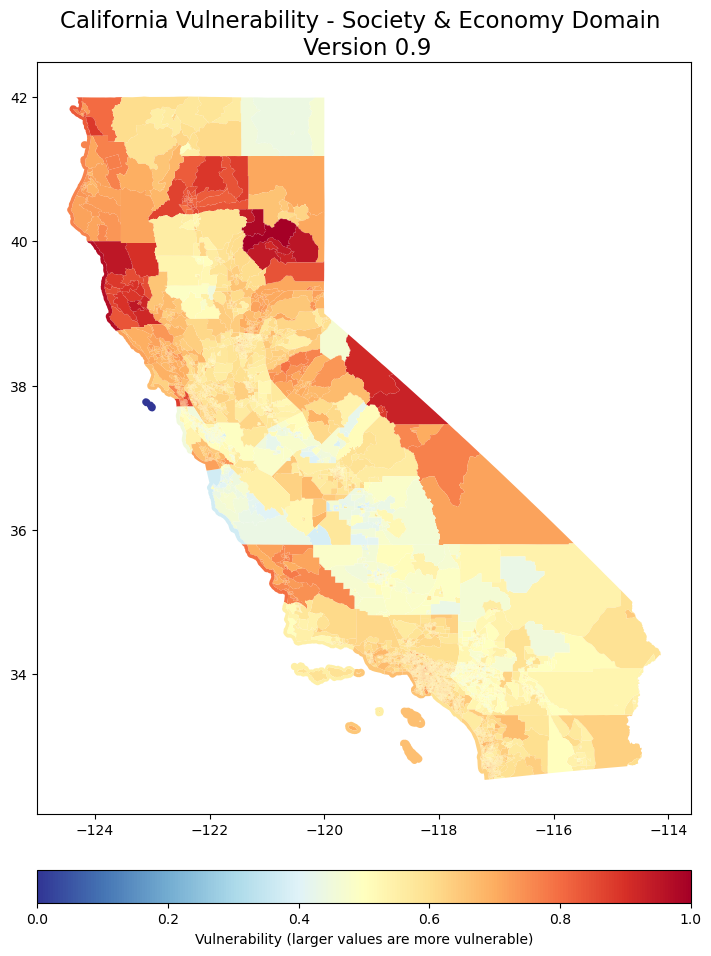

In [98]:
# Merge the DataFrames
df2 = min_max_standardized_society_economy_domain.merge(ca_boundaries, on='GEOID')

# Convert to GeoDataFrame with the correct CRS
df2 = gpd.GeoDataFrame(df2, geometry='geometry', crs=4269)

# Check for invalid geometries
invalid_geometries = df2[~df2['geometry'].is_valid]
print("Number of invalid geometries:", len(invalid_geometries))

# Check if there are any geometries left
if len(df2) == 0:
    print("No valid geometries remaining. Cannot plot.")
else:
    # Set up the figure
    fig, ax = plt.subplots(1, 1, figsize=(7, 10), layout='compressed')

    # Plot the data
    plot = df2.plot(column='summed_indicators_society_economy_domain_min_max_standardized', 
             ax=ax, 
             vmin=0, vmax=1, 
             legend=True, 
             cmap='RdYlBu_r',
             legend_kwds={'label': 'Vulnerability (larger values are more vulnerable)', 'orientation': 'horizontal', 'shrink': 1.0, 'pad': 0.03})
    
     # Set title
    ax.set_title('California Vulnerability - Society & Economy Domain \n Version 0.9', fontsize = 16.5)

    # Display the plot
    plt.show()


## Selecting counties to be mapped, by the COUNTYFP number
* manually enter the names of the counties linked with their number

Number of invalid geometries: 0


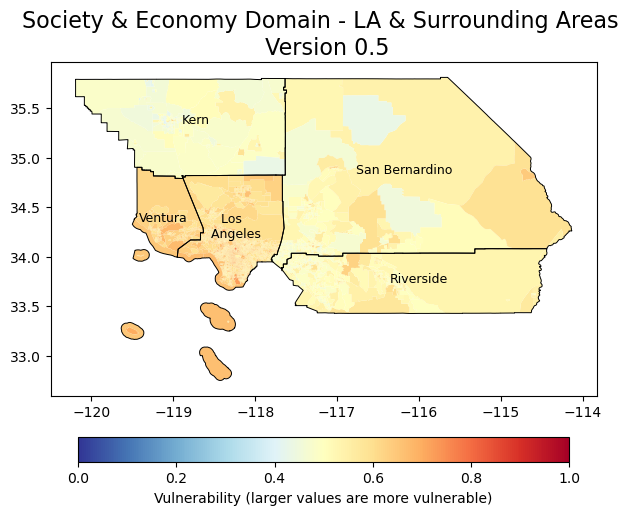

In [99]:
list_of_counties = [
    '037',
    '071',
    '065',
    '029',
    '111']

df2 = min_max_standardized_society_economy_domain.merge(ca_boundaries, on='GEOID')

# Filtering rows where COUNTYFP is in the list_of_counties
df2_filtered = df2[df2['COUNTYFP'].isin(list_of_counties)]

# Convert to GeoDataFrame with the correct CRS
df2_filtered = gpd.GeoDataFrame(df2_filtered, geometry='geometry', crs=4269)

# Check for invalid geometries
invalid_geometries = df2_filtered[~df2_filtered['geometry'].is_valid]
print("Number of invalid geometries:", len(invalid_geometries))

# Group by COUNTYFP and take the geometry of the first row in each group
county_boundaries = df2_filtered.dissolve(by='COUNTYFP')['geometry']

# Dictionary mapping county codes to labels
county_labels = {
    '037': 'Los \n Angeles',
    '071': 'San Bernardino',
    '065': 'Riverside',
    '029': 'Kern',
    '111': 'Ventura'
}

# Set up the figure
fig, ax = plt.subplots(1, 1, figsize=(6, 12), layout='compressed')

# Plot county boundaries
county_boundaries.boundary.plot(ax=ax, linewidth=0.7, edgecolor='black')

# Plot the data
df2_filtered.plot(column='summed_indicators_society_economy_domain_min_max_standardized', 
         ax=ax, 
         vmin=0, vmax=1, 
         legend=True, 
         cmap='RdYlBu_r', 
         legend_kwds={'label': 'Vulnerability (larger values are more vulnerable)', 'orientation': 'horizontal', 'shrink': 0.9, 'pad': -0.3})

# Add county labels
for county_code, label in county_labels.items():
    centroid = county_boundaries[county_code].centroid
    ax.text(centroid.x, centroid.y, label, weight='light', fontsize=9, ha='center', va='baseline')

ax.set_title('Society & Economy Domain - LA & Surrounding Areas \n Version 0.5', fontsize=16)

# Display the plot
plt.show()